In [1]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torchmetrics
import random


os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)

torch.manual_seed(42) 
torch.cuda.manual_seed(42)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3,1,1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3,1,1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        
    def forward(self,x):
        return self.conv(x)

In [3]:
class Unet(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 1, features = [64,128,256,512] ):
        super().__init__()
        
        self.encoder_convs = nn.ModuleList()
        for feature in features:
            self.encoder_convs.append(DoubleConv(in_channels, feature))
            in_channels = feature
            
        self.pool = nn.MaxPool2d(2,2)
        
        self.decoder_convs = nn.ModuleList()
        self.decoder_transConvs = nn.ModuleList()
        for feature in reversed(features):
            self.decoder_convs.append(DoubleConv(feature*2, feature))
            self.decoder_transConvs.append(nn.ConvTranspose2d(feature*2, feature, 2, 2))
            
            
        self.bottleNeck = DoubleConv(features[-1], features[-1]*2)
        
        self.output_conv = nn.Conv2d(features[0], out_channels, 1)
        
        
    def forward(self, x):
        
        skip_connections = []

        #encoder
        for conv in self.encoder_convs:
            x = conv(x)
            skip_connections.append(x)
            x = self.pool(x)
    
        #bottleneck
        x = self.bottleNeck(x)
        
        skip_connections = skip_connections[::-1]
    
            
        #decoder
        for transConv, skip, conv in zip(self.decoder_transConvs, skip_connections, self.decoder_convs):
            x = transConv(x)
            x = torch.cat((skip, x), dim=1)
            x = conv(x)
            
        return self.output_conv(x)
            
                    

In [4]:
import albumentations as A
from torchvision.transforms import v2
from torchvision.datasets import OxfordIIITPet
import torch.nn.functional as F

In [5]:
class PetsWithAug(OxfordIIITPet):
    def __init__(self, root, download=True, transform=None, target_types="segmentation", split="trainval"):
        super().__init__(root, download=download, transform=None, target_types=target_types, split=split)
        self.transform = transform
        
        
    def __getitem__(self, idx):
        img, mask = super().__getitem__(idx)
        img = np.array(img)
        mask = np.array(mask)
        mask[mask==2] = 0
        mask[mask==3] = 2
        
        if self.transform is not None:
            transformed = self.transform(image=img, mask=mask)
            img = transformed["image"]
            mask = transformed['mask']
            
            
        img = v2.ToDtype(torch.float32, scale=True)(torch.from_numpy(img)).permute(2,0,1)
        mask = torch.from_numpy(mask).long()
        mask = F.one_hot(mask, num_classes=3).permute(2,0,1)
        
            
        return img, mask

In [6]:
train_transforms = A.Compose([
    A.LongestMaxSize(320),
    A.PadIfNeeded(320, 320, border_mode=0),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.ShiftScaleRotate(border_mode=0),
    A.RandomBrightnessContrast(),
    A.ElasticTransform(border_mode=0),
    A.HueSaturationValue(),
    A.RGBShift(),
    A.RandomGamma(),
    A.GaussNoise(),
    A.Blur(),
])


test_transforms = A.Compose([
    A.LongestMaxSize(320),
    A.PadIfNeeded(320, 320, border_mode=0),
])

In [7]:
root_train = "/kaggle/working/train"
root_test = "/kaggle/working/test"

train_dataset = PetsWithAug(root_train, download=True, transform=train_transforms)

test_dataset = PetsWithAug(root_test, download=True, transform=test_transforms, split="test")

# len(test) = len(train), why.......

100%|██████████| 791918971/791918971 [00:22<00:00, 35133392.89it/s]


Extracting /kaggle/working/train/oxford-iiit-pet/images.tar.gz to /kaggle/working/train/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 14849809.50it/s]


Extracting /kaggle/working/train/oxford-iiit-pet/annotations.tar.gz to /kaggle/working/train/oxford-iiit-pet


100%|██████████| 791918971/791918971 [00:25<00:00, 31221050.29it/s]


Extracting /kaggle/working/test/oxford-iiit-pet/images.tar.gz to /kaggle/working/test/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 9270091.32it/s] 


Extracting /kaggle/working/test/oxford-iiit-pet/annotations.tar.gz to /kaggle/working/test/oxford-iiit-pet


In [8]:
from torch.utils.data import random_split
val_size = int(0.8 * len(test_dataset))
test_size = len(test_dataset) - val_size

val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

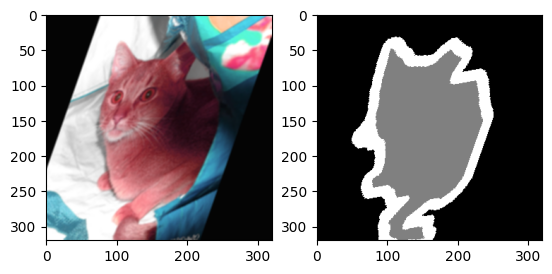

In [9]:
img, mask = train_dataset[0]
plt.subplot(1,2,1)
plt.imshow(img.permute(1,2,0))

plt.subplot(1,2,2)
plt.imshow(mask.permute(1,2,0).argmax(-1), cmap='gray')


In [10]:
LR = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 128
NUM_EPOCHS = 300


In [11]:
from torch.utils.data.dataloader import DataLoader


train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
val_dataloader = DataLoader(val_dataset, BATCH_SIZE*2, shuffle=False,num_workers=os.cpu_count(), pin_memory=True)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE*2, shuffle=False,num_workers=os.cpu_count(), pin_memory=True)

In [12]:
dice = torchmetrics.Dice(ignore_index=0).to(DEVICE)

def train_fn(train_loader, model, optim, loss_fn, amp_scaler):
    
    train_total_loss = 0
    
    loop = tqdm(train_loader)
    model.train()
    
    for batch_idx, (X_train, y_train) in enumerate(loop):
        X_train, y_train = X_train.to(DEVICE), y_train.float().to(DEVICE)
        
        with torch.cuda.amp.autocast():
            train_pred = model(X_train)
            loss = loss_fn(train_pred, y_train)
            
        
        optim.zero_grad(set_to_none='True')
        amp_scaler.scale(loss).backward()
        amp_scaler.step(optim)
        amp_scaler.update()
        
        train_total_loss += loss.item()
        
        
    return train_total_loss
        
def val_fn(val_loader, model, loss_fn) :
    
    val_total_loss = 0
    val_total_dice = 0
    
    model.eval()
    with torch.inference_mode():
        loop = tqdm(val_loader)
        for batch_idx, (X_val, y_val) in enumerate(loop):
            X_val, y_val = X_val.to(DEVICE), y_val.float().to(DEVICE)
            
            val_pred = model(X_val)
            loss = loss_fn(val_pred, y_val)
            
            val_total_dice += dice(val_pred.argmax(1), y_val.argmax(1)).item()
            val_total_loss += loss.item()
            
        
    return val_total_loss, val_total_dice



def save_checkpoint(model, optim, scheduler, epoch, scaler):
    torch.save({
    "model": model.state_dict(),
    "optim": optim.state_dict(),
    "random_states": {"python_rng_state": random.getstate(), 
                      "np_rng_state": np.random.get_state(), 
                      "torch_rng_state": torch.get_rng_state(),
                      "cuda_rng_state": torch.cuda.get_rng_state(),
                      },
    "scheduler": scheduler.state_dict(),
    "scaler": scaler.state_dict()

},
    f"/kaggle/working/epoch_{epoch}.pt")
    
    
def load_checkpoint(checkpoint, model, optim, scheduler, scaler):
    model.load_state_dict(checkpoint['model'])
    optim.load_state_dict(checkpoint['optim'])

    scheduler.load_state_dict(checkpoint['scheduler'])
    scaler.load_state_dict(checkpoint['scaler'])

    random.setstate(checkpoint['random_states']['python_rng_state'])
    np.random.set_state(checkpoint['random_states']['np_rng_state'])
    torch.set_rng_state(checkpoint['random_states']['torch_rng_state'])
    torch.cuda.set_rng_state(checkpoint['random_states']['cuda_rng_state'])

In [13]:
model = Unet(in_channels=3, out_channels=3, features=[32,64,128,256])
model = nn.DataParallel(model).to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=5e-5)
amp_scaler = torch.cuda.amp.GradScaler()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, patience=3)

In [14]:
cp = torch.load("/kaggle/input/unet-checkpoint/epoch_28.pt")
load_checkpoint(cp, model, optim, scheduler, amp_scaler)

In [15]:
for epoch in range(29, NUM_EPOCHS):
    
    train_loss = train_fn(train_dataloader, model, optim, loss_fn, amp_scaler)
    
    val_loss, val_dice = val_fn(val_dataloader, model, loss_fn)
    
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_dice /= len(val_dataloader)
    
    scheduler.step(val_loss)
    
    print(f"epoch_{epoch}:   train loss = {train_loss:.3f},   val loss = {val_loss:.3f}, val dice = {val_dice:.3f}")
    
    save_checkpoint(model, optim, scheduler, epoch, amp_scaler)


100%|██████████| 12/12 [00:34<00:00,  2.84s/it]


epoch_29:   train loss = 0.266,   val loss = 0.257, val dice = 0.789


100%|██████████| 12/12 [00:29<00:00,  2.43s/it]


epoch_30:   train loss = 0.262,   val loss = 0.253, val dice = 0.790


100%|██████████| 12/12 [00:29<00:00,  2.47s/it]


epoch_31:   train loss = 0.259,   val loss = 0.242, val dice = 0.796


100%|██████████| 12/12 [00:29<00:00,  2.46s/it]


epoch_32:   train loss = 0.258,   val loss = 0.255, val dice = 0.787


100%|██████████| 12/12 [00:29<00:00,  2.46s/it]


epoch_33:   train loss = 0.253,   val loss = 0.237, val dice = 0.802


100%|██████████| 12/12 [00:29<00:00,  2.46s/it]


epoch_34:   train loss = 0.250,   val loss = 0.233, val dice = 0.805


100%|██████████| 12/12 [00:29<00:00,  2.46s/it]


epoch_35:   train loss = 0.251,   val loss = 0.241, val dice = 0.796


100%|██████████| 12/12 [00:30<00:00,  2.54s/it]


epoch_36:   train loss = 0.248,   val loss = 0.232, val dice = 0.807


100%|██████████| 12/12 [00:30<00:00,  2.55s/it]


epoch_37:   train loss = 0.246,   val loss = 0.239, val dice = 0.797


100%|██████████| 12/12 [00:29<00:00,  2.45s/it]


epoch_38:   train loss = 0.246,   val loss = 0.230, val dice = 0.806


100%|██████████| 12/12 [00:29<00:00,  2.49s/it]


epoch_39:   train loss = 0.242,   val loss = 0.230, val dice = 0.807


100%|██████████| 12/12 [00:29<00:00,  2.45s/it]


epoch_40:   train loss = 0.241,   val loss = 0.228, val dice = 0.808


100%|██████████| 12/12 [00:29<00:00,  2.44s/it]


epoch_41:   train loss = 0.239,   val loss = 0.242, val dice = 0.801


  0%|          | 0/29 [00:11<?, ?it/s]


KeyboardInterrupt: 

(-0.5, 319.5, 319.5, -0.5)

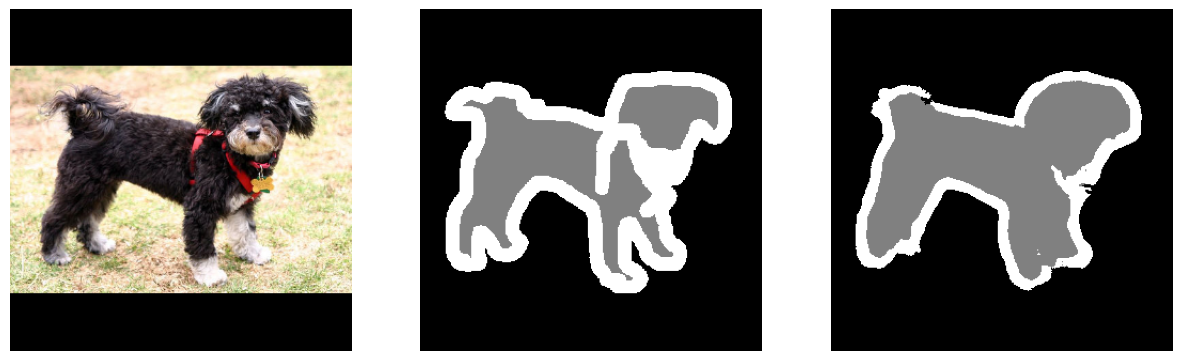

In [28]:
img, mask = test_dataset[10]

model.eval()
with torch.inference_mode():
    pred = model(img.unsqueeze(0).to(DEVICE))

figure = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img.permute(1,2,0))
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(mask.permute(1,2,0).argmax(-1), cmap='gray')
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred.squeeze().cpu().permute(1,2,0).argmax(-1), cmap='gray')
plt.axis("off")

### I didnt have a goal to get high metrics